In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pylab as plt
import warnings

%matplotlib inline

warnings.filterwarnings(action='ignore')

### 读取数据

- 分别构建训练接和测试集（验证集）
- DataLoader 来迭代数据

In [2]:
# 定义参数
input_size = 28  # 图像的总尺寸 28*28
num_classes = 10  # 标签的种类
num_epochs = 3  # 训练循环周期
batch_size = 64  # 一个批次的大小，64张图片
learning_rate = 0.0001 #学习率

In [3]:
# 训练集
train_dataset = datasets.MNIST(
    root='dataset/', train=True, transform=transforms.ToTensor(), download=True)

# 测试集
test_dataset = datasets.MNIST(
    root='dataset/', train=False, transform=transforms.ToTensor())

# 构建 batch 数据
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True,
)

## 查看数据集中的样例

- 使用 test_loader 的数据

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
example_data.shape

torch.Size([64, 1, 28, 28])

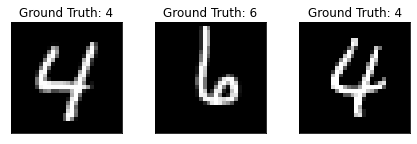

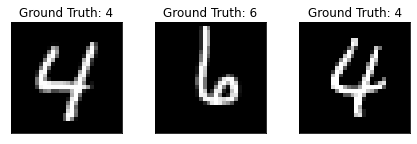

In [6]:
fig = plt.figure()

for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
    
fig

## 卷积网络模块构建

- 一般卷积层、relu 层、池化层写成一个类
- 卷积最后结果还是一个特征图，需要把图转换成向量才能做分类任务或回归任务

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(       # 输入大小：1，28，28
            nn.Conv2d(
                in_channels=1,            # 灰度图
                out_channels=16,          # 要得到多少个特诊
                kernel_size=5,            # 卷积核大小
                stride=1,                 # 步长
                # 如果希望卷积后大小和原来一样，需要设置 padding = (kernel_size-1)/2 if strude = 1
                padding=2,
            ),
            nn.ReLU(),                     # relu 层
            nn.MaxPool2d(kernel_size=2),   # 进行池化操作（2x2 区域），输出结果为：16, 14, 14
        )
        self.conv2 = nn.Sequential(        # 下一个输入是 16, 14, 14
            nn.Conv2d(16, 32, 5, 1, 2),    # 输出 32, 14, 14
            nn.ReLU(),                     # relu 层
            nn.MaxPool2d(2)                # 输出 32, 7, 7
        )
        self.out = nn.Linear(32*7*7, 10)   # 全连接层得到的结果
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)          # flatten 操作，结果为：batch_size, 32 * 7 * 7
        output = self.out(x)
        return output

## 准确率作为评估标准

In [8]:
# 评估函数
def accuracy(predictions, labels):
    pred = torch.max(predictions.data, 1)[1] 
    rights = pred.eq(labels.data.view_as(pred)).sum() 
    return rights, len(labels)

## 训练网络模型

In [9]:
# 实例化
net = CNN() 
#损失函数
criterion = nn.CrossEntropyLoss() 
#优化器
optimizer = optim.Adam(net.parameters(), lr=0.001) #定义优化器，普通的随机梯度下降算法

#开始训练循环
for epoch in range(num_epochs):
    #当前epoch的结果保存下来
    train_rights = [] 
    
    for batch_idx, (data, target) in enumerate(train_loader):  #针对容器中的每一个批进行循环
        net.train()                             
        output = net(data) 
        loss = criterion(output, target) 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        right = accuracy(output, target) 
        train_rights.append(right) 

    
        if batch_idx % 100 == 0: 
            
            net.eval() 
            val_rights = [] 
            
            for (data, target) in test_loader:
                output = net(data) 
                right = accuracy(output, target) 
                val_rights.append(right)
                
            #准确率计算
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
    
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTraining set accuracy: {:.2f}%\tTest set accuracy: {:.2f}%'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data, 
                100. * train_r[0].numpy() / train_r[1], 
                100. * val_r[0].numpy() / val_r[1]))
            torch.save(net.state_dict(), 'results/model.pth')
            torch.save(optimizer.state_dict(), 'results/optimizer.pth')

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.285724	Training set accuracy: 7.81%	Test set accuracy: 10.32%
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.182356	Training set accuracy: 75.67%	Test set accuracy: 91.70%
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.300249	Training set accuracy: 84.33%	Test set accuracy: 93.73%
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.157097	Training set accuracy: 87.90%	Test set accuracy: 95.85%
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.068983	Training set accuracy: 89.89%	Test set accuracy: 96.61%
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.013333	Training set accuracy: 91.24%	Test set accuracy: 97.17%
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.134649	Training set accuracy: 92.22%	Test set accuracy: 97.45%
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.118037	Training set accuracy: 92.94%	Test set accuracy: 97.90%
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.028242	Training set accuracy: 93.47%	Test set accuracy: 97.71%
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.032020	Tra